In [1]:
import os
import torch
import matplotlib.pyplot as plt
from skimage.io import imread

# Util function for loading meshes
from pytorch3d.io import load_obj

# Data structures and functions for rendering
from pytorch3d.structures import Meshes, Textures
from pytorch3d.renderer import (
    look_at_view_transform,
    OpenGLPerspectiveCameras, 
    PointLights, 
    DirectionalLights, 
    Materials, 
    RasterizationSettings, 
    MeshRenderer, 
    MeshRasterizer,  
    TexturedPhongShader
)

# add path for demo utils functions 
import sys
sys.path.append(os.path.abspath(''))

from utils import image_grid

In [2]:
# Setup
device = torch.device("cuda:0")
torch.cuda.set_device(device)

# Set paths
DATA_DIR = "/home/hyosung/ImageDataset/PoseDataset/YCB_Video_Dataset/models/010_potted_meat_can/"
obj_filename = os.path.join(DATA_DIR, "textured.obj")

# Load obj file
verts, faces, aux = load_obj(obj_filename)
faces_idx = faces.verts_idx.to(device)
verts = verts.to(device)

# Get textures from the outputs of the load_obj function
# the `aux` variable contains the texture maps and vertex uv coordinates. 
# Refer to the `obj_io.load_obj` function for full API reference. 
# Here we only have one texture map for the whole mesh. 
verts_uvs = aux.verts_uvs[None, ...].to(device)       # (N, V, 2)
faces_uvs = faces.textures_idx[None, ...].to(device)  # (N, F, 3)
tex_maps = aux.texture_images
texture_image = list(tex_maps.values())[0]
texture_image = texture_image[None, ...].to(device)   # (N, H, W, 3)

# Create a textures object
tex = Textures(verts_uvs=verts_uvs, faces_uvs=faces_uvs, maps=texture_image)

# Create a meshes object with textures
mesh = Meshes(verts=[verts], faces=[faces_idx], textures=tex)

In [3]:
print(faces_uvs)

tensor([[[     0,      1,      2],
         [     3,      4,      5],
         [     3,      5,      6],
         ...,
         [255944, 263597, 263598],
         [263598, 255948, 255944],
         [255948, 263598, 255630]]], device='cuda:0')


(-0.5, 4095.5, 4095.5, -0.5)

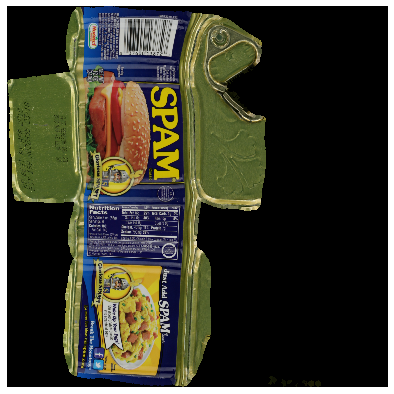

In [4]:
plt.figure(figsize=(7,7))
plt.imshow(texture_image.squeeze().cpu().numpy())
plt.grid("off")
plt.axis('off')

In [5]:
# Initialize an OpenGL perspective camera.
R, T = look_at_view_transform(0.2, 45, 45)
cameras = OpenGLPerspectiveCameras(device=device, R=R, T=T)

# Define the settings for rasterization and shading. Here we set the output image to be of size
# 512x512. As we are rendering images for visualization purposes only we will set faces_per_pixel=1
# and blur_radius=0.0. Refer to rasterize_meshes.py for explanations of these parameters. 
raster_settings = RasterizationSettings(
    image_size=512, 
    blur_radius=0.0, 
    faces_per_pixel=1, 
    bin_size=0
)

# Place a point light in front of the object
lights = PointLights(device=device, location=[[1.0, 1.0, -2.0]])

# Create a phong renderer by composing a rasterizer and a shader. The textured phong shader will 
# interpolate the texture uv coordinates for each vertex, sample from a texture image and 
# apply the Phong lighting model
renderer = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=cameras, 
        raster_settings=raster_settings
    ),
    shader=TexturedPhongShader(
        device=device, 
        cameras=cameras,
        lights=lights
    )
)
# Change specular color to green and change material shininess 
materials = Materials(
    device=device,
    specular_color=[[1.0, 1.0, 1.0]],
    shininess=10.0
)

(-0.5, 511.5, 511.5, -0.5)

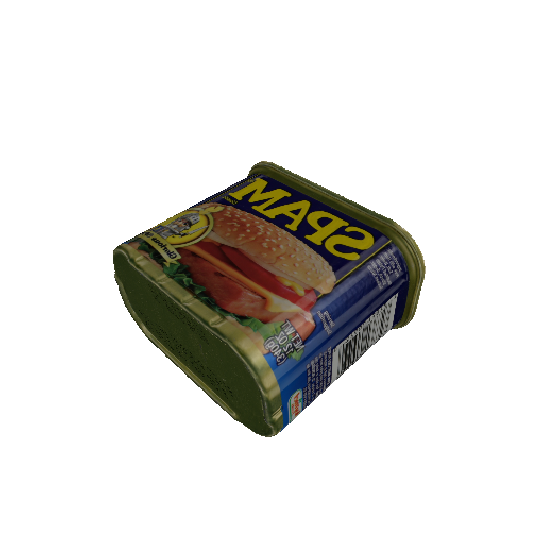

In [6]:
lights.location = torch.tensor([40.0, 40.0, 20], device=device)[None]
images = renderer(mesh, lights=lights, materials=materials, cameras=cameras)
plt.figure(figsize=(10, 10))
plt.imshow(images[0, ..., :3].cpu().numpy())
plt.grid("off")
plt.axis("off")

In [7]:
# Set batch size - this is the number of different viewpoints from which we want to render the mesh.
batch_size = 20

# Create a batch of meshes by repeating the cow mesh and associated textures. 
# Meshes has a useful `extend` method which allows us do this very easily. 
# This also extends the textures. 
meshes = mesh.extend(batch_size)

# Get a batch of viewing angles. 
elev = torch.linspace(0, 360, batch_size)
azim = torch.linspace(0, 360, batch_size)

R, T = look_at_view_transform(dist=0.13, elev=elev, azim=azim)
cameras = OpenGLPerspectiveCameras(device=device, R=R, T=T)

# Move the light back in front of the object
lights.location = torch.tensor([[0.0, 10.0, 2.0]], device=device)

In [8]:
images = renderer(meshes, cameras=cameras, lights=lights)

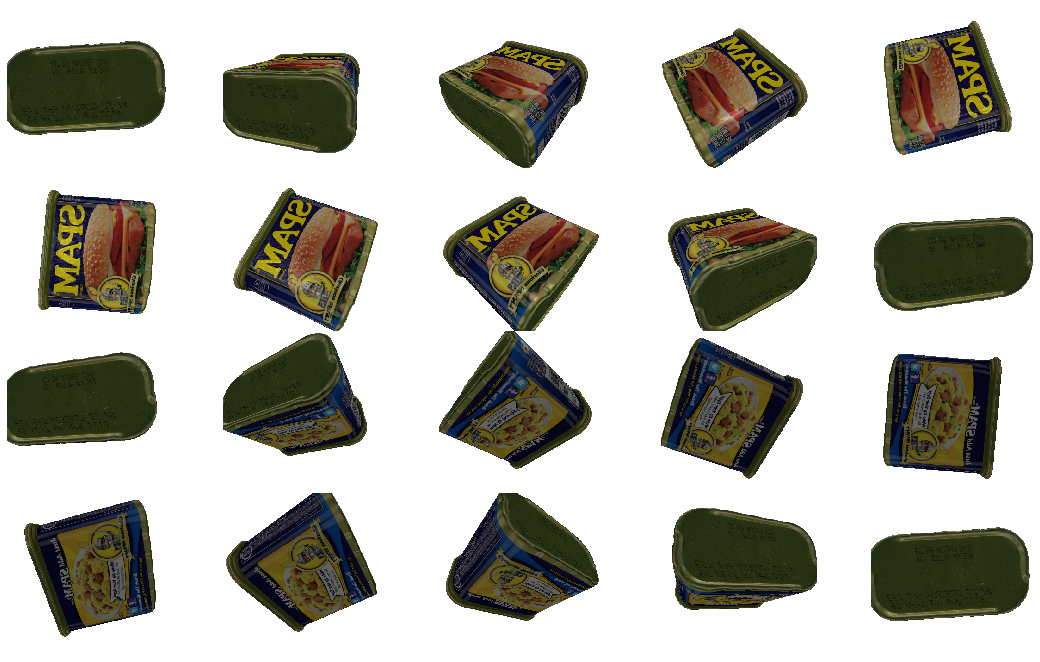

In [9]:
image_grid(images.cpu().numpy(), rows=4, cols=5, rgb=True)

In [10]:
import scipy.io
SYN_DATA_DIR = "/home/hyosung/ImageDataset/PoseDataset/YCB_Video_Dataset/data_syn/"
obj_filename = os.path.join(SYN_DATA_DIR, "000016-meta.mat")
mat = scipy.io.loadmat(obj_filename)

cls_indexes: [19.  9. 10. 14.  7.  4.]
cls_index: 1


(-0.5, 511.5, 511.5, -0.5)

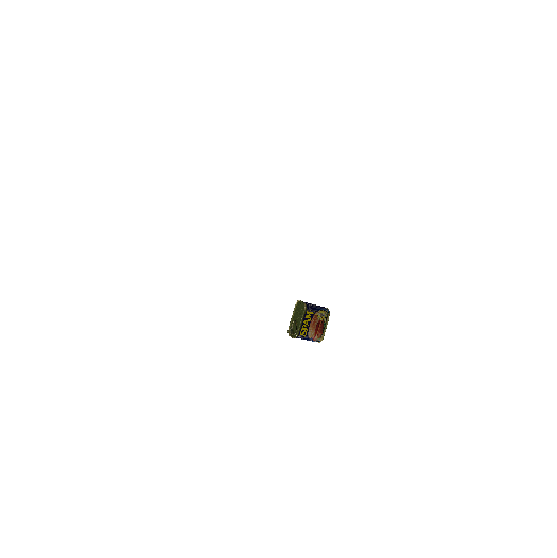

In [11]:
_arg_arg# Initialize an OpenGL perspective camera.
# R, T = look_at_view_transform(0.2, 45, 45)
target_index = 9 # SPAM CAN
cls_index = None
cls_indexes = mat['cls_indexes'][0]
print(f'cls_indexes: {cls_indexes}')
for i in range(len(cls_indexes)):    
    if int(cls_indexes[i]) == target_index:
        cls_index = i
        print(f'cls_index: {cls_index}')
        break
R = torch.tensor(mat['poses'][..., cls_index][:,:3]).view(1,3,3)
T = torch.tensor(mat['poses'][..., cls_index][:,3]).view(1,3)
cameras = OpenGLPerspectiveCameras(device=device, R=R, T=T)

# Define the settings for rasterization and shading. Here we set the output image to be of size
# 512x512. As we are rendering images for visualization purposes only we will set faces_per_pixel=1
# and blur_radius=0.0. Refer to rasterize_meshes.py for explanations of these parameters. 
raster_settings = RasterizationSettings(
    image_size=512, 
    blur_radius=0.0, 
    faces_per_pixel=1, 
    bin_size=0
)

# Place a point light in front of the object
lights = PointLights(device=device, location=[[1.0, 1.0, -2.0]])

# Create a phong renderer by composing a rasterizer and a shader. The textured phong shader will 
# interpolate the texture uv coordinates for each vertex, sample from a texture image and 
# apply the Phong lighting model
renderer = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=cameras, 
        raster_settings=raster_settings
    ),
    shader=TexturedPhongShader(
        device=device, 
        cameras=cameras,
        lights=lights
    )
)
# Change specular color to green and change material shininess 
materials = Materials(
    device=device,
    specular_color=[[1.0, 1.0, 1.0]],
    shininess=10.0
)

lights.location = torch.tensor([40.0, 40.0, 20], device=device)[None]
images = renderer(mesh, lights=lights, materials=materials, cameras=cameras)
plt.figure(figsize=(10, 10))
# plt.imshow(images[0, ..., :3].cpu().numpy())
image = images[0, ..., :3].cpu().numpy()
image = image[::-1, :, :]
plt.imshow(image)
plt.grid("off")
plt.axis("off")